<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/02_baseline_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Baseline Model Evaluation

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/FIT3199-FYP/python-lib')

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

from scipy.sparse import hstack

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

### Initialize Mlflow server

In [4]:
from getpass import getpass
import os

os.environ['MLFLOW_TRACKING_USERNAME'] = "Zfeng0207"
os.environ['MLFLOW_TRACKING_PASSWORD'] = ""
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = "stroke-prediction-dagshub-repo"

mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')
print(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

https://dagshub.com/Zfeng0207/stroke-prediction-dagshub-repo.mlflow


### Import Recurrent Stroke Patient Data

In [5]:
recurrent_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FIT3199-FYP/input/00_recurrent_stroke_patient.csv')

In [6]:
recurrent_df.drop(columns=['dod','numeric_part',"icd_code", "icd_version", "numeric_part", "dod", "icd_title"],inplace=True)
recurrent_df = recurrent_df.dropna(subset=['charttime'])

In [7]:
recurrent_df.columns

Index(['subject_id', 'stay_id', 'charttime', 'temperature', 'heartrate',
       'resprate', 'o2sat', 'sbp', 'dbp', 'rhythm', 'pain', 'seq_num',
       'Stroke_Y/N', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group'],
      dtype='object')

## Preprocessing Pipeline

In [8]:
recurrent_df.isna().sum()

,0
subject_id,0
stay_id,0
charttime,0
temperature,32373
heartrate,3100
resprate,4090
o2sat,5341
sbp,3324
dbp,3324
rhythm,65248


In [9]:
recurrent_df.dtypes

,0
subject_id,int64
stay_id,int64
charttime,object
temperature,float64
heartrate,float64
resprate,float64
o2sat,float64
sbp,float64
dbp,float64
rhythm,object


In [22]:
import pandas as pd
import numpy as np
import pickle
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from fuzzywuzzy import process, fuzz

# Define column groups
right_skewed_features = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp"]
date_features = ["anchor_age", "anchor_year"]
text_feature = "pain"  # Text column for TF-IDF
categorical_features = ["gender", "rhythm", "subject_id", "stay_id", "seq_num", "anchor_year_group"]  # Include grouped rhythm
target_column = "Stroke_Y/N"
untouched_features = ["charttime"]

# ✅ Function to Interpolate Missing Values
def interpolate_features(df):
    df = df.copy()
    for col in ["heartrate", "resprate", "o2sat", "sbp", "dbp"]:
        df[col] = df[col].interpolate(method="linear")
    return df

# ✅ Function to Fuzzy Match 'rhythm' Column
reference_groups = [
    "Normal Sinus Rhythm", "Sinus Arrhythmia", "Sinus Bradycardia", "Sinus Tachycardia",
    "Atrial Fibrillation", "Atrial Flutter", "Paced Rhythm", "Junctional Rhythm",
    "First Degree AV Block", "Bundle Branch Block (BBB)", "Supraventricular Tachycardia (SVT)",
    "Ventricular Ectopy (PVCs, Bigeminy, Trigeminy)", "Unknown / Invalid Entry"
]

def match_rhythm(rhythm):
    if pd.isna(rhythm):
        return "Unknown / Invalid Entry"
    rhythm = rhythm.lower().strip()
    best_match, score = process.extractOne(rhythm, reference_groups, scorer=fuzz.token_sort_ratio)
    return best_match if score > 80 else "Unknown / Invalid Entry"

def match_rhythm_column(df):
    df = df.copy()
    df["rhythm"] = df["rhythm"].apply(match_rhythm)
    return df

# ✅ Function to Replace Nulls in 'pain' Column with "null"
def replace_null_pain(df):
    df = df.copy()
    df["pain"] = df["pain"].fillna("null")
    return df

# ✅ TF-IDF for Text Column
vectorizer = TfidfVectorizer(stop_words="english", max_features=500)

# ✅ Preprocessing for Numerical & Categorical Features
log_transformer = FunctionTransformer(np.log1p, validate=False)
mm_scaler = MinMaxScaler()
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

def to_dense(x):
    return x.toarray() if hasattr(x, "toarray") else x

# ✅ ColumnTransformer to Process All Features
preprocessor = ColumnTransformer([
    ("log", log_transformer, right_skewed_features),  # Log transform
    ("scaler", mm_scaler, date_features),  # Scale date-related features
    ("tfidf", Pipeline([
        ("vectorizer", vectorizer),
        ("to_dense", FunctionTransformer(to_dense, accept_sparse=True))
    ]), text_feature),  # Convert TF-IDF output to dense
    ("ohe", ohe, categorical_features),  # One-hot encode categorical features
], sparse_threshold=0)  # Ensure dense output

# ✅ Pipeline to Apply Preprocessing
pipeline = Pipeline([
    ("replace_null_pain", FunctionTransformer(replace_null_pain, validate=False)),  # Step 1: Replace NaN in pain column
    ("interpolation", FunctionTransformer(interpolate_features, validate=False)),  # Step 2: Interpolation
    ("fuzzy_matching", FunctionTransformer(match_rhythm_column, validate=False)),  # Step 3: Fuzzy matching
    ("preprocessor", preprocessor)  # Step 4: Feature transformations
])

# ✅ Save Pipeline to a Pickle File
with open("preprocessing_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

print("✅ Preprocessing pipeline saved successfully!")


✅ Preprocessing pipeline saved successfully!


# Time Series Splitting

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset (assuming it's already preprocessed)
df = recurrent_df.copy()

# Step 1: Ensure chronological order (important for time-series models)
df = df.sort_values(by=["subject_id", "stay_id", "charttime"])

# Step 2: Assign patients to Train/Val/Test splits
subject_ids = df["subject_id"].unique()
train_subjects, temp_subjects = train_test_split(subject_ids, test_size=0.2, random_state=42)
val_subjects, test_subjects = train_test_split(temp_subjects, test_size=0.5, random_state=42)

# Step 3: Select all stay_ids for each split
train_df = df[df["subject_id"].isin(train_subjects)]
val_df = df[df["subject_id"].isin(val_subjects)]
test_df = df[df["subject_id"].isin(test_subjects)]  # Keeps all stays per patient

# Step 4: Ensure no patient leakage between splits
assert train_df["subject_id"].nunique() + val_df["subject_id"].nunique() + test_df["subject_id"].nunique() == len(subject_ids), "Overlap detected!"

# Save or use the datasets
# train_df.to_csv("train_data.csv", index=False)
# val_df.to_csv("val_data.csv", index=False)
# test_df.to_csv("test_data.csv", index=False)

print("✅ Train, Validation, and Test sets successfully created!")


✅ Train, Validation, and Test sets successfully created!


In [49]:
train_df[train_df['subject_id']==10003299]

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain,seq_num,Stroke_Y/N,gender,anchor_age,anchor_year,anchor_year_group
0,10003299,31931401,2183-02-26 20:26:00,97.7,63.0,15.0,97.0,146.0,65.0,NaN,0,1,0,F,65,2173,2008 - 2010
1,10003299,31931401,2183-02-26 21:43:00,NaN,51.0,16.0,97.0,131.0,42.0,NaN,0,1,0,F,65,2173,2008 - 2010
2,10003299,31931401,2183-02-26 22:03:00,NaN,57.0,19.0,100.0,142.0,54.0,NaN,NaN,1,0,F,65,2173,2008 - 2010
3,10003299,31931401,2183-02-27 02:20:00,NaN,54.0,18.0,97.0,129.0,56.0,NaN,0,1,0,F,65,2173,2008 - 2010
4,10003299,31931401,2183-02-27 06:26:00,98.7,61.0,15.0,98.0,123.0,53.0,NaN,NaN,1,0,F,65,2173,2008 - 2010
5,10003299,31931401,2183-02-27 10:11:00,98.6,54.0,18.0,97.0,141.0,72.0,NaN,NaN,1,0,F,65,2173,2008 - 2010
6,10003299,31931401,2183-02-27 12:30:00,NaN,55.0,20.0,97.0,116.0,67.0,NaN,0,1,0,F,65,2173,2008 - 2010
7,10003299,31931401,2183-02-27 15:28:00,99.1,55.0,20.0,99.0,145.0,74.0,NaN,0,1,0,F,65,2173,2008 - 2010
8,10003299,32908139,2181-10-22 11:48:00,97.4,65.0,16.0,97.0,153.0,70.0,NaN,0,1,0,F,65,2173,2008 - 2010
9,10003299,32908139,2181-10-22 11:48:00,97.4,65.0,16.0,97.0,153.0,70.0,NaN,0,2,1,F,65,2173,2008 - 2010


In [51]:
test_df


,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain,seq_num,Stroke_Y/N,gender,anchor_age,anchor_year,anchor_year_group
0,10165902,39299543,2152-09-18 16:22:00,97.3,79.0,16.0,96.0,190.0,90.0,NaN,NaN,1,0,F,91,2152,2014 - 2016
1,10165902,39299543,2152-09-18 16:22:00,97.3,79.0,16.0,96.0,190.0,90.0,NaN,NaN,2,0,F,91,2152,2014 - 2016
2,10165902,39299543,2152-09-18 16:22:00,97.3,79.0,16.0,96.0,190.0,90.0,NaN,NaN,3,0,F,91,2152,2014 - 2016
3,10165902,39299543,2152-09-18 16:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,F,91,2152,2014 - 2016
4,10165902,39299543,2152-09-18 16:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0,F,91,2152,2014 - 2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,19889178,32724636,2116-06-03 18:51:00,96.5,110.0,20.0,94.0,134.0,84.0,NaN,5,1,1,F,76,2116,2014 - 2016
1450,19889178,32724636,2116-06-03 20:16:00,NaN,110.0,18.0,97.0,140.0,92.0,NaN,5,1,1,F,76,2116,2014 - 2016
1451,19889178,32724636,2116-06-03 21:32:00,NaN,104.0,20.0,99.0,143.0,79.0,NaN,5,1,1,F,76,2116,2014 - 2016
1452,19889178,32724636,2116-06-03 22:50:00,NaN,108.0,19.0,99.0,161.0,98.0,NaN,NaN,1,1,F,76,2116,2014 - 2016


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# Assume 'df' is your dataset
X = recurrent_df.drop(columns=["Stroke_Y/N"])
y = recurrent_df["Stroke_Y/N"]

# TimeSeriesSplit with 3 folds
tscv = TimeSeriesSplit(n_splits=3)

fold_results = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    print(f"Processing Fold {fold}...")

    # Split train and test data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Fit pipeline on train data
    pipeline.fit(X_train)

    # Transform train and test data
    X_train_transformed = pipeline.transform(X_train)
    X_test_transformed = pipeline.transform(X_test)

    # Store results
    fold_results.append({
        "fold": fold,
        "X_train": X_train_transformed,
        "y_train": y_train,
        "X_test": X_test_transformed,
        "y_test": y_test
    })

    print(f"Fold {fold} | Train Size: {X_train.shape[0]} | Test Size: {X_test.shape[0]}")


Processing Fold 1...
Fold 1 | Train Size: 16926 | Test Size: 16924
Processing Fold 2...


Fold 2 | Train Size: 33850 | Test Size: 16924
Processing Fold 3...


Fold 3 | Train Size: 50774 | Test Size: 16924


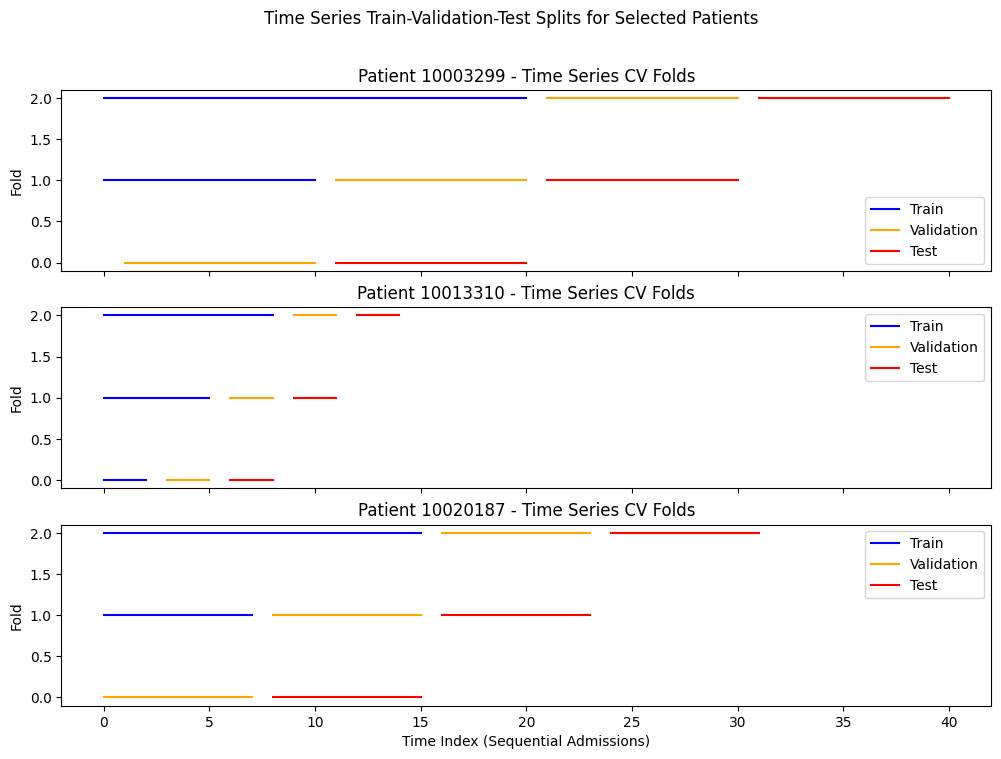

In [34]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Select a few example patients for visualization
example_patients = recurrent_df["subject_id"].unique()[:3]  # Select first 3 patients

# Plot each patient’s fold splits
fig, axes = plt.subplots(len(example_patients), 1, figsize=(12, 8), sharex=True)

if len(example_patients) == 1:
    axes = [axes]  # Ensure axes is iterable even with one patient

for ax, subject_id in zip(axes, example_patients):
    group = recurrent_df[recurrent_df["subject_id"] == subject_id]
    X = group[right_skewed_features].values

    ax.set_title(f"Patient {subject_id} - Time Series CV Folds")

    for fold, (train_val_idx, test_idx) in enumerate(tscv.split(X)):
        # Further split train_val into train and validation
        train_idx = train_val_idx[:-len(test_idx)]  # Majority for training
        val_idx = train_val_idx[-len(test_idx):]  # Last portion for validation

        # Plot train, validation, and test as connected sequences
        ax.plot(train_idx, [fold] * len(train_idx), color="blue", linestyle="-", label="Train" if fold == 0 else "")
        ax.plot(val_idx, [fold] * len(val_idx), color="orange", linestyle="-", label="Validation" if fold == 0 else "")
        ax.plot(test_idx, [fold] * len(test_idx), color="red", linestyle="-", label="Test" if fold == 0 else "")

    ax.set_ylabel("Fold")
    ax.legend()

plt.xlabel("Time Index (Sequential Admissions)")
plt.suptitle("Time Series Train-Validation-Test Splits for Selected Patients")
plt.show()


For each patient:

The first row (Fold 0) → Uses early visits as training, then selects a later visit for validation, and even later for testing.
The second row (Fold 1) → Expands training with more past visits, shifts validation forward, and chooses a new later visit for testing.
The third row (Fold 2) → The pattern repeats, progressively including more past visits for training and delaying the test set.

# Data Preprocessing

In [ ]:
# Load dataset
df = recurrent_df.copy()  # Ensure `processed_df` is preloaded

# Convert `charttime` to datetime for correct time-based sorting
df["charttime"] = pd.to_datetime(df["charttime"])

# Sort data by patient, stay_id, and time
df = df.sort_values(by=["subject_id", "stay_id", "charttime"])

#### Impute Missing Health Reading Values

In [ ]:
df.loc[:, 'heartrate'] = df['heartrate'].interpolate(method='linear')
df.loc[:, 'resprate'] = df['resprate'].interpolate(method='linear')
df.loc[:, 'o2sat'] = df['o2sat'].interpolate(method='linear')
df.loc[:, 'sbp'] = df['sbp'].interpolate(method='linear')
df.loc[:, 'dbp'] = df['dbp'].interpolate(method='linear')

#### Grouping Rhythm Groups

In [ ]:
import pandas as pd
from fuzzywuzzy import process, fuzz

# Define reference groups (manually curated categories)
reference_groups = [
    "Normal Sinus Rhythm",
    "Sinus Arrhythmia",
    "Sinus Bradycardia",
    "Sinus Tachycardia",
    "Atrial Fibrillation",
    "Atrial Flutter",
    "Paced Rhythm",
    "Junctional Rhythm",
    "First Degree AV Block",
    "Bundle Branch Block (BBB)",
    "Supraventricular Tachycardia (SVT)",
    "Ventricular Ectopy (PVCs, Bigeminy, Trigeminy)",  # Includes PVCs, Bigeminy, Trigeminy
    "Unknown / Invalid Entry"  # For noise or unclear values
]


# Function to normalize and fuzzy match rhythms
def match_rhythm(rhythm):
    if pd.isna(rhythm):
        return None
    rhythm = rhythm.lower().strip()  # Normalize text

    best_match, score = process.extractOne(rhythm, reference_groups, scorer=fuzz.token_sort_ratio)

    if score > 80:  # Only group if confidence is high
        return best_match
    return rhythm  # Keep original if no good match

# Apply fuzzy matching to the DataFrame column
df['grouped_rhythm'] = df['rhythm'].apply(match_rhythm)


In [ ]:
print(f"Before running fuzzyword match: {df['rhythm'].nunique()} rhythm groups")
print(f"After running fuzzyword match: {df['grouped_rhythm'].nunique()} rhythm groups")

### Baseline Model Training

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naïve Bayes": GaussianNB()
    # "Support Vector Machine": SVC(probability=True)
}

# Start MLflow experiment
mlflow.set_experiment("Stroke Prediction Experiment")

# Train and evaluate each model
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        mlflow.sklearn.autolog()

        # Train model on all training patients
        model.fit(X_train, y_train)

        # Evaluate on test patients
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None  # Some models don't support predict_proba

        # Calculate evaluation metrics
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc_roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

        # Log metrics in MLflow
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        if auc_roc is not None:
            mlflow.log_metric("auc_roc", auc_roc)

        # Print model performance immediately after logging
        print(f"{model_name} - Accuracy: {acc:.4f}, "
              f"Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, "
              f"F1 Score: {f1:.4f}, "
              f"AUC-ROC: {auc_roc:.4f}" if auc_roc is not None else "")

        print("-" * 80)  # Separator for readability


In [ ]:
# # Save X_test and y_test
# X_test.to_csv("X_test.csv", index=False)
# y_test.to_csv("y_test.csv", index=False)

# # Save X_val and y_val
# X_val.to_csv("X_val.csv", index=False)
# y_val.to_csv("y_val.csv", index=False)

# print("Test and validation sets saved successfully.")


### SHAP and LIME Analysis

#### SHAP

In [ ]:
#  create a SHAP explainer and calculate SHAP values for the test set
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(X_test)


In [ ]:
import shap
import matplotlib.pyplot as plt

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test)


##### Summary Plot Insights

Notes:

**Observations**


**Key Takeaway**


In [ ]:
X_test

##### Dependence Plot Insights

Notes:


**Observations**


**Key Takeaway**



#### LIME

In [ ]:
# lime_explanation = explainer_lime.explain_instance(X_test.iloc[0].values, model.predict_proba, num_features=10)
# lime_explanation.as_pyplot_figure()
# plt.show()

##### Insights
**Observations**



**Key Takeaway**
